# HFF Turbidity Analysis

## Business Understanding

Henry's Fork Foundation aims to preserve and restore the natural water quality of the Henry's Fork of the Snake River and its watershed. While their responsibilities are many, one of their chief aims is to use modern scientific techniques to keep tabs on the river and ensure local industrial and commercial practices are not interfering with its overall health and aesthetics. In turn, the river provides habitat for local flora and fauna, not to mention a large portion of the tourism revenue for the surrounding towns in the form of sport fishing.

To ensure optimal fishing experience the water conditions must be within acceptable ranges. Turbidity is the measure of clarity of a liquid, and in this case is very important to this experience. According to my correspondence with their Senior Scientist, Rob Van Kirk, "Turbidity is the single biggest factor affecting fishing experience. Anglers can't see things like dissolved oxygen or nutrient concentrations, but they can see how clear or dirty the water is. By far the single biggest complaint I get about fishing conditions is how turbid the water is."

I have been tasked with assessing and modeling data from multiple sources to determine major factors and predictors that contribute to turbidity in the river. Using this analysis and its framework, future scientists may be able to forecast water clarity and even mitigate contributing factors.

## Data Understanding

The first dataset comes from the publically available sonde data at [HFF.org](https://henrysforkdata.shinyapps.io/scientific_website/). This data is updated every 15 minutes using an in-water monitoring device called a sonde. These devices measure water temperature, turbidity, dissolved oxygen, conductivity, phytoplankton, and cyanobacteria content. While the other factors can contribute to the turbidity of a system on their own, they do not provide a complete picture.

We chose the sonde at this location because it is the head of one of the best regarded fishing areas, and its location just a few hundred yards downstream from Island Park Dam makes turbidity there less predictable and of higher concern. Determining the contributing factors to water clarity here could prove valuable in understanding how activity and management at Island Park reservoir impact the downstream water conditions.

The second dataset comes from the [US Bureau of Reclamation](https://www.usbr.gov/projects/index.php?id=151) and contains historical data regarding the water in island park reservoir, including in/outflow, elevation, and overall change in volume. While this data does not directly address the clarity of the water, the rate of flow in and out of the reservoir may kick up sediment and with the amount of exposed shoreline may affect the rate at which the shoreline erodes into the reservoir. This data dates back to 1929 which may be interesting to explore further once we have established the relevant tools for the job.

The third dataset comes from the [USDA Snotel Natural Resources Conservation Service
National Water and Climate Center](https://wcc.sc.egov.usda.gov/reportGenerator/view/customChartReport/daily/start_of_period/546:ID:SNTL%7Cid=%22%22%7Cname/CurrentWY,CurrentWYEnd/WTEQ::median_1981,WTEQ::median_1991,PREC::average_1981,PREC::median_1991?fitToScreen=false&useLogScale=false) which provides snow and climate monitoring at specific sites across the entire USA. The dataset we have is localized to our region, which we narrow further to sites that affect the watershed into the reservoir's tributaries. This has been collected since 1988 for this locale, which we again narrow into a timeframe we can use. The data includes the temperature at these sites, the daily and average precipitation, and the amount of water currently at the site in the form of snow.

## Data Preparation

First we import relevant libraries and format the data to be readable as a timeseries. Then, in order to get the data into a time scale that is relevant to the other datasets we downsample to daily frequency and split the data into training and testing sets. The data is in a timeseries, which precludes traditional random train/test splitting, and must be done using values that are in sequence. In this case, we take the most recent year with relatively complete data as the test set, and the rest of the complete years as the training data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import STL

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Import raw Island Park Dam sonde data
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert date to index and DateTime format
ipe_df = ipe_df.rename(columns={'contTime': 'date'})
ipe_df['date'] = pd.to_datetime(ipe_df.date)
data = ipe_df.drop(['date'], axis=1)
data.index = ipe_df.date

In [4]:
# Downsample data to daily frequency 
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1)

In [6]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [7]:
ipe_train = ipe_interp['2016':'2020']

In [8]:
ipe_test = ipe_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_29700\3605300567.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_test = ipe_interp['2021']


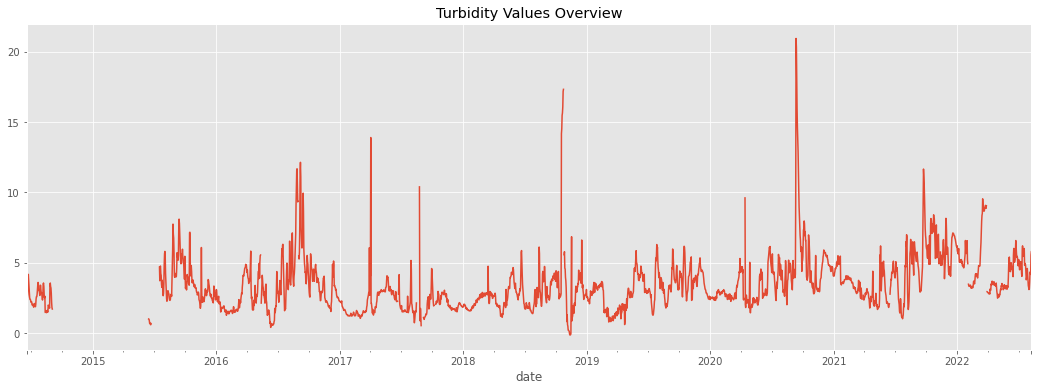

In [9]:
ipe_daily['Turb_FNU'].plot(figsize=(18,6))
plt.title('Turbidity Values Overview');

When we inspect the turbidity values here, we see there is a rather large gap early on in the time series, and a few smaller ones later on. These may bee too large for simple interpolation, especially with the high variance in data values over a short period of time. For this reason we will later drop these sections. Other NaN values will be interpolated over using the splining method to attempt to anticipate the patterns before modeling.

In [10]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [11]:
# drop redundant columns
hydro_df.drop(['volume.af', 'smoothed.vol', 'elevation.ft',
                   'smoothed.elev', 'surfacearea.acres'], axis=1, inplace=True)

In [12]:
hydro_df = hydro_df['2014':'2022']

In [13]:
# set the range of the data to the same as the sonde data
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [14]:
hydro_df_train = hydro_interp['2016':'2020']

In [15]:
hydro_df_test = hydro_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_29700\1673822024.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  hydro_df_test = hydro_interp['2021']


In [16]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP', 'WE.TMIN', 'WE.TMAX', 'CC.TMIN', 'CC.TMAX',
       'IP.TMIN', 'IP.TMAX'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE', 'CC.DP', 'CC.AP',
       'CC.SWE', 'IP.TAVE', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [17]:
climate_df = climate_df['2014':'2022']

In [18]:
clim_interp = climate_df.interpolate(method='spline', order=2)

In [19]:
climate_df_train = clim_interp['2016':'2020']

In [20]:
climate_df_test = clim_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_29700\3356747189.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  climate_df_test = clim_interp['2021']


Next, we combine the dataframes into their final training and testing sets, and inspect the resulting dataframe to ensure the structure looks correct, and there are no NaN values.

In [21]:
# Merge to create training set
final_train = pd.merge(climate_df_train, hydro_df_train, on=['date'])
final_train = pd.merge(final_train, ipe_train, on=['date'])

In [22]:
# Merge to create testing set
final_test = pd.merge(climate_df_test, hydro_df_test, on=['date'])
final_test = pd.merge(final_test, ipe_test, on=['date'])

In [23]:
# Inspect dataframe
final_test

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.0,0.0,8.2,7.3,19.0,0.0,4.0,3.6,23.0,0.0,...,286.371429,336.0,473.218701,450.186231,4.062128,0.367234,0.577872,6.902447,3.568787,136.174468
2021-01-02,19.0,0.2,8.4,7.6,20.0,0.3,4.3,3.9,24.0,0.3,...,311.414286,331.0,395.996470,437.342115,4.080745,0.375833,0.578333,6.966354,3.563354,135.673958
2021-01-03,22.0,0.4,8.8,7.9,24.0,0.1,4.4,4.0,27.0,0.3,...,305.214286,329.0,390.736122,441.850473,4.290000,0.358333,0.582187,6.949583,3.566958,135.616667
2021-01-04,25.0,0.7,9.5,8.6,26.0,0.4,4.8,4.5,30.0,0.3,...,296.328571,317.0,374.016665,446.983281,4.392083,0.338125,0.583333,6.870833,3.595531,135.275000
2021-01-05,23.0,0.6,10.1,9.0,25.0,0.2,5.0,4.7,29.0,0.4,...,288.200000,335.0,359.163160,441.158729,4.609674,0.344130,0.589783,7.111739,3.626120,135.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.0,0.5,17.3,12.9,13.0,0.4,11.5,6.5,17.0,0.6,...,345.381446,217.0,227.585681,315.894845,6.513646,0.608750,-0.044271,7.552292,3.786125,133.888542
2021-12-28,2.0,0.0,17.3,13.0,3.0,0.0,11.5,6.5,9.0,0.0,...,333.787929,226.0,392.313095,308.990468,6.322292,0.511563,-0.044167,7.495729,3.791698,133.850000
2021-12-29,6.0,0.3,17.6,13.3,8.0,0.1,11.6,6.6,11.0,0.3,...,304.581729,229.0,299.410937,320.837058,6.224894,0.510319,-0.062872,7.367872,3.828872,134.678723


In [24]:
# Check for NaNs
final_train.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [25]:
# Check for NaNs
final_test.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [26]:
# determine the lowest negative value so we can add that to all values to make the dataframe positive before scaling
final_train.min()

WE.TAVE                -5.000000
WE.DP                   0.000000
WE.AP                   0.000000
WE.SWE                  0.000000
CC.TAVE                -4.000000
CC.DP                   0.000000
CC.AP                   0.000000
CC.SWE                  0.000000
IP.TAVE                -8.000000
IP.DP                   0.000000
IP.AP                   0.000000
IP.SWE                  0.000000
net.evap.af         -1486.560444
delta.V.af          -2171.061429
regQ.cfs               71.900000
gain.cfs              -64.733023
smoothed.natQ.cfs     295.220945
Turb_FNU               -0.118526
Chloro_RFU             -0.332188
BGA_RFU                -0.453542
ODO_mgL                 3.373684
Temp_C                  2.639990
Cond_muSCm             71.887474
dtype: float64

In [27]:
# Logarithmic transformation after subtracting the most negative value 
final_train_log = np.log((final_train+2172))
final_test_log = np.log((final_test+2172))

C:\Users\harri\AppData\Local\Temp\ipykernel_29700\469378547.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(final_train['2020'])


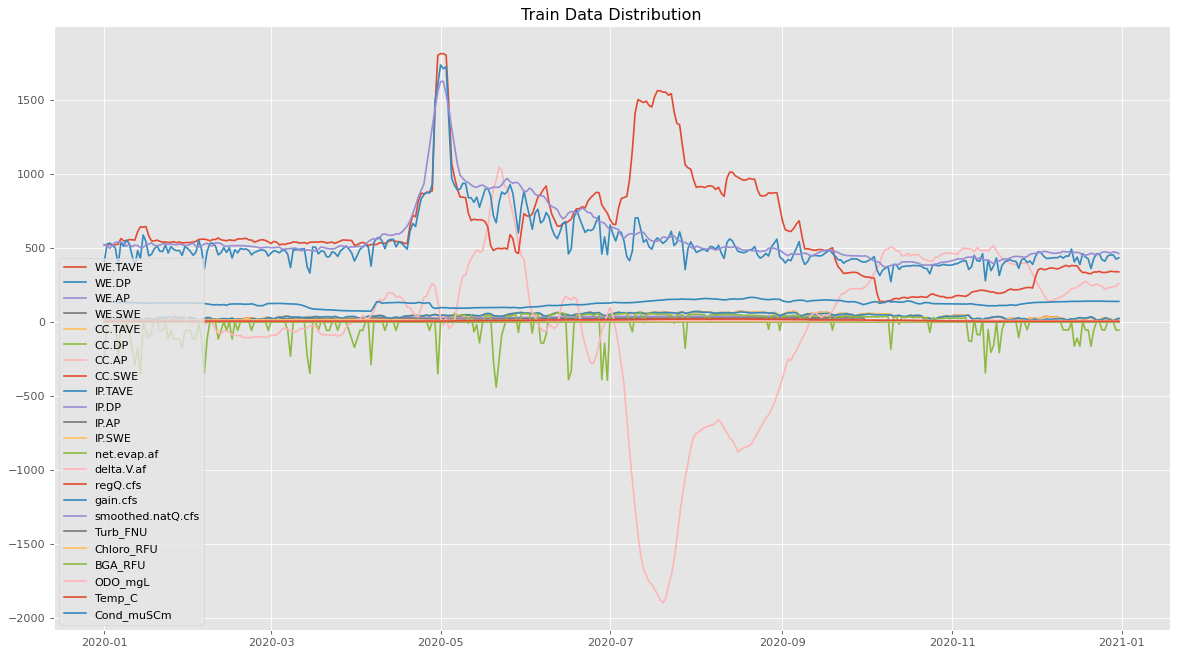

In [28]:
# Visualise train set for curiosity's sake
plt.figure(figsize=(18,10), dpi=80)
plt.plot(final_train['2020'])
plt.legend(final_train)
plt.title('Train Data Distribution');

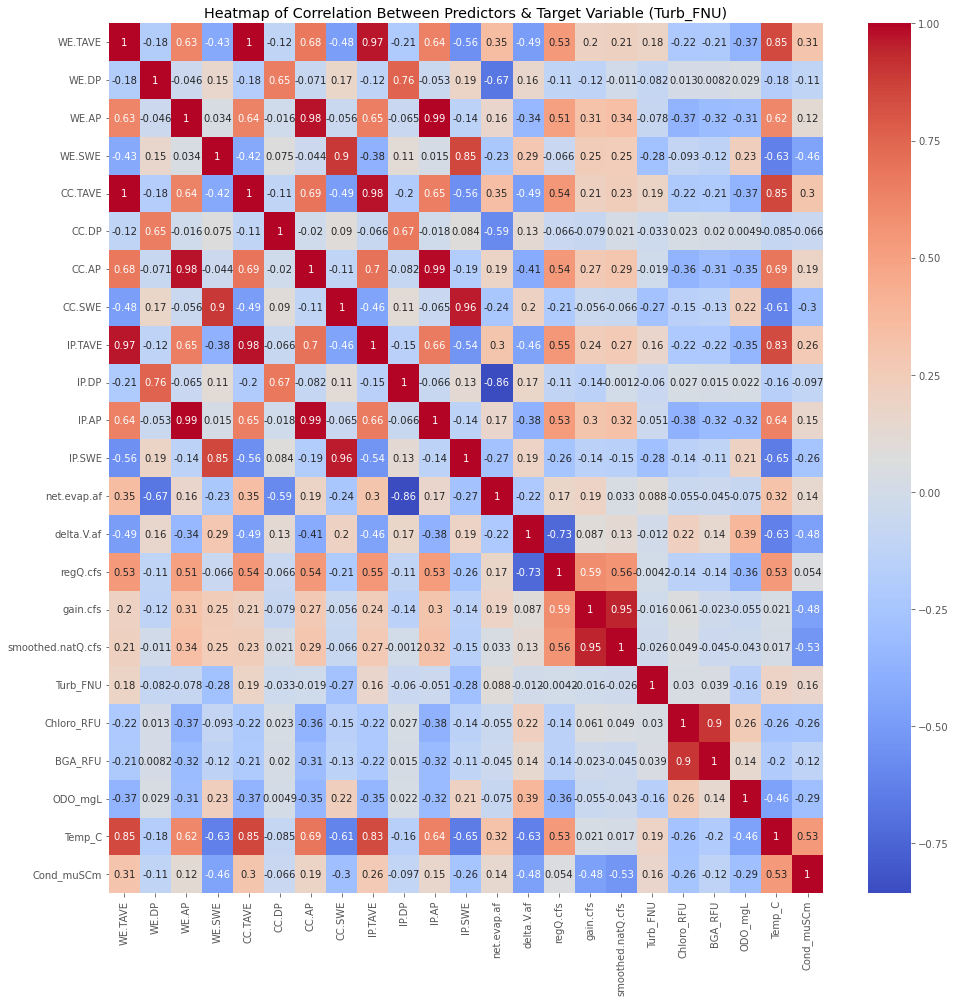

In [29]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))
# set up correlation matrix
corr = final_train.corr()
sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Turb_FNU)");
plt.show();

Here, we have a correlation matrix which shows the raw correlation between values in the dataset. This displays potential sources of collinearity where the correlation is high. It also shows that none of the variables are directly correlated very highly with turbidity, meaning more advanced regression is required to determine the relationships.

## OLS Model

First, we determine feature importance for a simple model to give an idea of the weights of the explanatory variables on turbidity. An OLS model allows us to use multivariate regression to capture the variance in the data.

In [30]:
# Instantiate and fit the OLS model, and provide output
ols = OLS(exog=final_train.drop(['Turb_FNU'], axis=1), endog=final_train['Turb_FNU'])
ols_model = ols.fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              299.4
Date:                Wed, 24 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:47:10   Log-Likelihood:                         -3565.4
No. Observations:                1827   AIC:                                      7175.
Df Residuals:                    1805   BIC:                                      7296.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [31]:
# Display standard deviations
final_train.std()

WE.TAVE               16.602699
WE.DP                  0.278735
WE.AP                 17.329576
WE.SWE                10.776551
CC.TAVE               16.611129
CC.DP                  0.193697
CC.AP                  9.495161
CC.SWE                 5.003882
IP.TAVE               16.159206
IP.DP                  0.169281
IP.AP                 10.288354
IP.SWE                 5.481206
net.evap.af          105.403773
delta.V.af           516.610946
regQ.cfs             336.144960
gain.cfs             219.347114
smoothed.natQ.cfs    235.757751
Turb_FNU               1.927556
Chloro_RFU             1.999588
BGA_RFU                0.641085
ODO_mgL                1.114011
Temp_C                 5.159372
Cond_muSCm            17.618043
dtype: float64

In [32]:
# Predict on the test set
ols_pred = ols_model.predict(final_test.drop(['Turb_FNU'], axis=1))

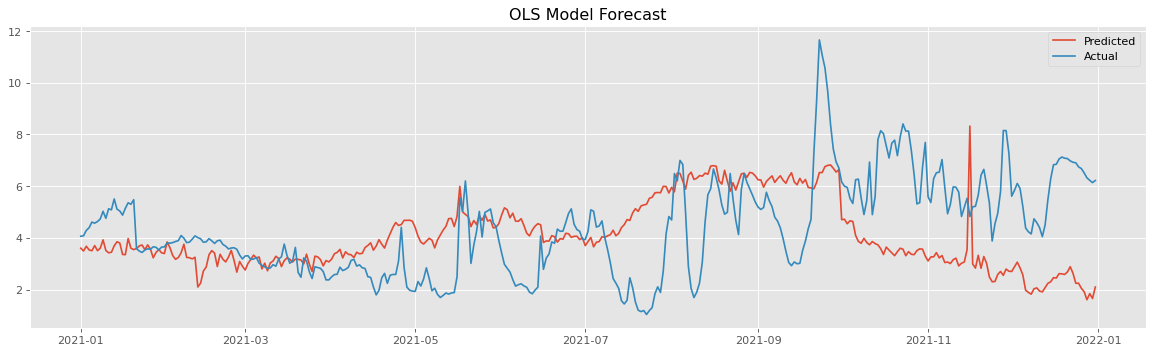

In [33]:
# Plot OLS model forecast
plt.figure(figsize=(18,5), dpi=80)
plt.plot(ols_pred, label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.title('OLS Model Forecast')
plt.legend();

In [34]:
# Calculate RMSE
dibrinse = ((final_test['Turb_FNU'])-ols_pred)
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

0.5311789017236513

This adjusted R2 value shows that the variance in the turbidity is about 79% captured by the explanatory variables according to this model. This does not necessarily mean our model can't get any better than this, but it may represent a loose ballpark for the upper bounds of how accurately we can predict the turbidity using basic methods. Additionally, multicollinearity is high here, which is to be expected. This can be mitigated by eliminating columns or using models that eliminate multicollinearity issues going forward.

The Durbin-Watson score here is low, implying the variance of the data is not constant throughout. This makes sense in this case, as even though the data is from the same time frame, it comes from three completely different sources. This is something to keep in mind and can be eliminated using a transformation. 

The coefficients here represent the amount of change in turbidity for a one unit change in the explanatory variable in question. Higher values can denote a larger influence in this simple model, but it is important to take into mind the scale of the variable and compare, which is why the standard deviation is included for context. If the coefficient is large but the scale of the variable is also large, that might not mean as significant an influence.

The p values here also should be taken in with a grain of salt, as a p value lower than 0.05 should mean we can reject the null hypothesis that the variable has no influence on the turbidity, and the converse is also true, that if the p value is higher than 0.05 we can reject the alternative hypothesis that the variable does have a significant influence. Using our background knowledge however, we know that high amounts of chlorophyll and BGA are linked to higher turbidity, which does not seem to be the case in this regression.

From this, we see that the factors that have a direct impact via low p values and high coefficients relative to their scale are all temperatures at the Snotel sites, which are collinear, as well as the amount of snow at the Island Park and Crab Creek sites. As snow melts at the Crab Creek site, the turbidity increases at Island Park, and then as the amount of snow increases at Island Park, the turbidity also increases, reflecting the effects of increased inflow into the reservoir from this inlet and possibly the effects of inclement weather respectively, as in the latter the average precipitation also has a low p value. The amount of dissolved oxygen also negatively correlates with the turbidity, showing that the conditions that increase turbidity also decrease the amount of biologically available oxygen. The conductivity positively correlates with the turbidity, which tracks, as the amount of dissolved salts and other inorganic compounds could hamper water clarity.

RMSE value averages the square of all the errors, and then takes the square root to get the number back into the scale of the data. The RMSE for the predictions vs actual here is surprisingly low at 0.53, meaning given the information, this model is actually quite good.

The drawback of this model is that the data you provide it will often already contain the turbidity value, given the sonde. It can, however, be used to estimate the turbidity in cases where we have an idea going in of what the values for the predictors might be, as in the prediction for 2021. This means that this model cannot forecast very well without being given information about the future.

## VAR Model

The VAR model is a multivariate timeseries model that allows us to quickly compare the past and present verisions of a dataset to examine their relationship. This model does well for recurring patterns by creating vectors out of the predictor variables relationships, and then continuing the patterns for all variables.

In [35]:
#creating the train and validation set
train = final_train_log
valid = final_test_log

In [36]:
#make final predictions
model = VAR(endog=train.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
# Untransform and reformat the predictions
yhat_unt = pd.DataFrame((np.exp(yhat))-2172)
yhat_unt.set_index(final_test.index, inplace=True)
yhat_unt.columns = final_test.columns

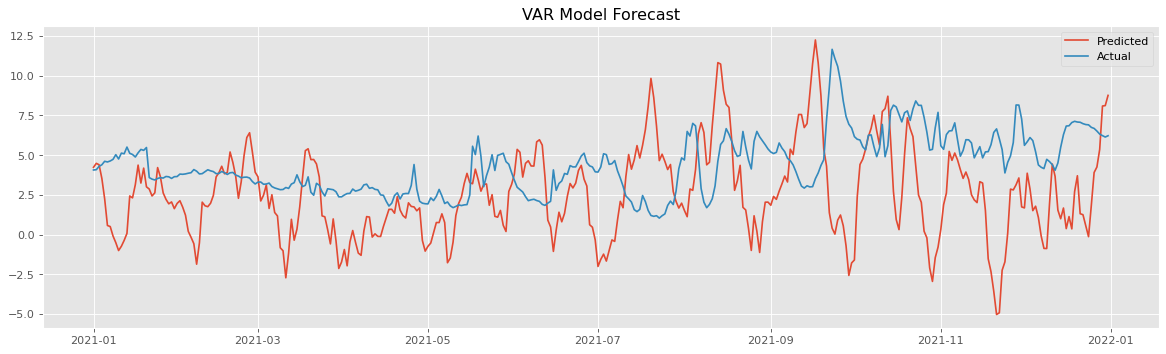

In [38]:
# Plot the predictions vs the actual values for 2021
plt.figure(figsize=(18,5), dpi=80)
plt.plot(yhat_unt['Turb_FNU'], label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.title('VAR Model Forecast')
plt.legend();

In [39]:
# Calculate RMSE
dibrinse = ((final_test['Turb_FNU']**2)-yhat_unt['Turb_FNU'])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

4.463655258001275

The above is the predicted values for turbidity using VAR. This result is if we were to predict the entire year without knowing any of the values for the predictor variables for the year. This shows that although the explanatory variables do contribute to the turbidity value, they themselves are not predictable due to major contributing factors not explained by the data.

The RMSE here is much worse, at 4.5, as the forecast has no information about the future values for which it is predicting, explanatory variables or otherwise. That said, the overall variance gets larger as the year goes on in both the predicted and actual values much like the years prior. The highs also seems to match the nearby peaks in the actual data as well. 

## LSTM Neural Network

Long Short Term Memory(LSTM) networks are a style of Recurrent Neural Network(RNN). RNNs are machine learning models that use the previous values to help predict the future values, and are the neural networks generally best suited to dealing with time series values. This works in theory, but these models tend toward stasis as they try to forecast further into the future. This essentially means that while the most recent values still affect the model, as the old ones get further from the current prediction, they begin to lose importance.

LSTM networks alleviate this problem by selectively forgetting information that it deems unimportant, while retaining the information it deems important. It determines the importance of the previous input using a sigmoid function to and then uses the same function along with the current input to create a vector telling the model how much of the new information to include in the new memory state. This new memory state is then retained and considered in with the next input, and so on.

In [40]:
# Make train and test sets
X_train = final_train.drop(['Turb_FNU'], axis=1)
y_train = final_train.Turb_FNU
X_test = final_test.drop(['Turb_FNU'], axis=1)
y_test = final_test.Turb_FNU

In [41]:
# Build the LSTM Neural Network

m = Sequential()
m.add(LSTM(units=50, return_sequences=True,
          input_shape=(X_train.shape[1],1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.1))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [42]:
# Fit the model to the data
history = m.fit(X_train, y_train, epochs=3000, batch_size=25, verbose=1)

Epoch 1/3000
74/74 [==============================] - 3s 8ms/step - loss: 4.4133
Epoch 2/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.7008
Epoch 3/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3829
Epoch 4/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3603
Epoch 5/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3452
Epoch 6/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.2937
Epoch 7/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3172
Epoch 8/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.4504
Epoch 9/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.3199
Epoch 10/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.2338
Epoch 11/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.1781
Epoch 12/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.1739
Epoch 13/3000
74/74 [====

74/74 [==============================] - 1s 8ms/step - loss: 1.6714
Epoch 102/3000
74/74 [==============================] - 1s 9ms/step - loss: 1.8570
Epoch 103/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.7438
Epoch 104/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3789
Epoch 105/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3078
Epoch 106/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3306
Epoch 107/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3270
Epoch 108/3000
74/74 [==============================] - 1s 9ms/step - loss: 1.2535
Epoch 109/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.2269
Epoch 110/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.2509
Epoch 111/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.1714
Epoch 112/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.2158
Epoch 113/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.9184
Epoch 200/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8414
Epoch 201/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8140
Epoch 202/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8122
Epoch 203/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8173
Epoch 204/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8362
Epoch 205/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8278
Epoch 206/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8476
Epoch 207/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8057
Epoch 208/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9674
Epoch 209/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9359
Epoch 210/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.0532
Epoch 211/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.6672
Epoch 298/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6199
Epoch 299/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6345
Epoch 300/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.6958
Epoch 301/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.6075
Epoch 302/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5654
Epoch 303/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5594
Epoch 304/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5999
Epoch 305/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5908
Epoch 306/3000
74/74 [==============================] - 1s 9ms/step - loss: 1.2594
Epoch 307/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9082
Epoch 308/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8069
Epoch 309/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.5018
Epoch 396/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4646
Epoch 397/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4652
Epoch 398/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5487
Epoch 399/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5809
Epoch 400/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.6355
Epoch 401/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4653
Epoch 402/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4336
Epoch 403/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4620
Epoch 404/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4233
Epoch 405/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4594
Epoch 406/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4194
Epoch 407/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.5262
Epoch 494/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5328
Epoch 495/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4182
Epoch 496/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4172
Epoch 497/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3753
Epoch 498/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3766
Epoch 499/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3360
Epoch 500/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4139
Epoch 501/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5285
Epoch 502/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4480
Epoch 503/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4590
Epoch 504/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4025
Epoch 505/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.3284
Epoch 592/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2974
Epoch 593/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3066
Epoch 594/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2926
Epoch 595/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2802
Epoch 596/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2790
Epoch 597/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3129
Epoch 598/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2716
Epoch 599/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3023
Epoch 600/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2973
Epoch 601/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2962
Epoch 602/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3046
Epoch 603/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.3167
Epoch 690/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4468
Epoch 691/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3098
Epoch 692/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2853
Epoch 693/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2717
Epoch 694/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3786
Epoch 695/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3003
Epoch 696/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2678
Epoch 697/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2925
Epoch 698/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3070
Epoch 699/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2655
Epoch 700/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2370
Epoch 701/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.2738
Epoch 788/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2826
Epoch 789/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2543
Epoch 790/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2734
Epoch 791/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2589
Epoch 792/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2272
Epoch 793/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2280
Epoch 794/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2331
Epoch 795/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2335
Epoch 796/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2180
Epoch 797/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2257
Epoch 798/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2327
Epoch 799/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.2076
Epoch 886/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1937
Epoch 887/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2097
Epoch 888/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2105
Epoch 889/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2358
Epoch 890/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1979
Epoch 891/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2066
Epoch 892/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1945
Epoch 893/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2072
Epoch 894/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2209
Epoch 895/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2029
Epoch 896/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1981
Epoch 897/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.1907
Epoch 984/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2157
Epoch 985/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2093
Epoch 986/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1977
Epoch 987/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2093
Epoch 988/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2057
Epoch 989/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2490
Epoch 990/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2093
Epoch 991/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1941
Epoch 992/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1829
Epoch 993/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2000
Epoch 994/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1952
Epoch 995/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.1889
Epoch 1081/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1707
Epoch 1082/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2031
Epoch 1083/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2057
Epoch 1084/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1959
Epoch 1085/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2088
Epoch 1086/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1972
Epoch 1087/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1817
Epoch 1088/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1833
Epoch 1089/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1841
Epoch 1090/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1969
Epoch 1091/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1878
Epoch 10

74/74 [==============================] - 1s 8ms/step - loss: 0.1942
Epoch 1178/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2789
Epoch 1179/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2049
Epoch 1180/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1961
Epoch 1181/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1649
Epoch 1182/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1812
Epoch 1183/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1923
Epoch 1184/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2088
Epoch 1185/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1757
Epoch 1186/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3067
Epoch 1187/3000
74/74 [==============================] - 1s 10ms/step - loss: 0.1958
Epoch 1188/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1886
Epoch 1

74/74 [==============================] - 1s 9ms/step - loss: 0.2340
Epoch 1275/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2331
Epoch 1276/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1968
Epoch 1277/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1643
Epoch 1278/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2792
Epoch 1279/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1812
Epoch 1280/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2006
Epoch 1281/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1805
Epoch 1282/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1734
Epoch 1283/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1717
Epoch 1284/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1618
Epoch 1285/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1457
Epoch 12

74/74 [==============================] - 1s 9ms/step - loss: 0.4343
Epoch 1372/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2335
Epoch 1373/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2163
Epoch 1374/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1473
Epoch 1375/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1431
Epoch 1376/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1436
Epoch 1377/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1221
Epoch 1378/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1187
Epoch 1379/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1253
Epoch 1380/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1635
Epoch 1381/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1386
Epoch 1382/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1411
Epoch 13

74/74 [==============================] - 1s 8ms/step - loss: 0.1407
Epoch 1469/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1328
Epoch 1470/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1262
Epoch 1471/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1193
Epoch 1472/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1081
Epoch 1473/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1179
Epoch 1474/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1311
Epoch 1475/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1364
Epoch 1476/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1652
Epoch 1477/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1572
Epoch 1478/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1265
Epoch 1479/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1192
Epoch 14

74/74 [==============================] - 1s 8ms/step - loss: 0.1325
Epoch 1566/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1279
Epoch 1567/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1233
Epoch 1568/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1208
Epoch 1569/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1282
Epoch 1570/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2163
Epoch 1571/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1477
Epoch 1572/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1292
Epoch 1573/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1216
Epoch 1574/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1783
Epoch 1575/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1337
Epoch 1576/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2382
Epoch 15

74/74 [==============================] - 1s 9ms/step - loss: 0.1057
Epoch 1663/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0962
Epoch 1664/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0946
Epoch 1665/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1046
Epoch 1666/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1032
Epoch 1667/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1468
Epoch 1668/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1449
Epoch 1669/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1047
Epoch 1670/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1016
Epoch 1671/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1132
Epoch 1672/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1061
Epoch 1673/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0966
Epoch 16

74/74 [==============================] - 1s 8ms/step - loss: 0.1082
Epoch 1760/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1063
Epoch 1761/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1000
Epoch 1762/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0905
Epoch 1763/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1279
Epoch 1764/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1390
Epoch 1765/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1033
Epoch 1766/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1008
Epoch 1767/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1386
Epoch 1768/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2374
Epoch 1769/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1979
Epoch 1770/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1564
Epoch 17

74/74 [==============================] - 1s 9ms/step - loss: 0.1335
Epoch 1857/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1169
Epoch 1858/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1359
Epoch 1859/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1383
Epoch 1860/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 1861/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1185
Epoch 1862/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1237
Epoch 1863/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1456
Epoch 1864/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1285
Epoch 1865/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0962
Epoch 1866/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1071
Epoch 1867/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0943
Epoch 18

74/74 [==============================] - 1s 8ms/step - loss: 0.0896
Epoch 1954/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4349
Epoch 1955/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9621
Epoch 1956/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.7235
Epoch 1957/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5667
Epoch 1958/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3162
Epoch 1959/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2791
Epoch 1960/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4812
Epoch 1961/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2922
Epoch 1962/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2055
Epoch 1963/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1694
Epoch 1964/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1658
Epoch 19

74/74 [==============================] - 1s 8ms/step - loss: 0.1600
Epoch 2051/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1226
Epoch 2052/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1351
Epoch 2053/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1419
Epoch 2054/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1505
Epoch 2055/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1365
Epoch 2056/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1376
Epoch 2057/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1200
Epoch 2058/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1534
Epoch 2059/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1647
Epoch 2060/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1404
Epoch 2061/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1425
Epoch 20

74/74 [==============================] - 1s 8ms/step - loss: 0.1219
Epoch 2148/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1228
Epoch 2149/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1161
Epoch 2150/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1243
Epoch 2151/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1582
Epoch 2152/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1280
Epoch 2153/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1095
Epoch 2154/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1138
Epoch 2155/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1043
Epoch 2156/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1309
Epoch 2157/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1120
Epoch 2158/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1008
Epoch 21

74/74 [==============================] - 1s 8ms/step - loss: 0.1306
Epoch 2245/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1441
Epoch 2246/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1241
Epoch 2247/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1213
Epoch 2248/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1189
Epoch 2249/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1177
Epoch 2250/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0960
Epoch 2251/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1011
Epoch 2252/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1207
Epoch 2253/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1308
Epoch 2254/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1140
Epoch 2255/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1096
Epoch 22

74/74 [==============================] - 1s 9ms/step - loss: 0.2150
Epoch 2342/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2525
Epoch 2343/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2122
Epoch 2344/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1935
Epoch 2345/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2020
Epoch 2346/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1972
Epoch 2347/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1856
Epoch 2348/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1782
Epoch 2349/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1749
Epoch 2350/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1884
Epoch 2351/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1758
Epoch 2352/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1454
Epoch 23

74/74 [==============================] - 1s 9ms/step - loss: 0.1582
Epoch 2439/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1637
Epoch 2440/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1698
Epoch 2441/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1674
Epoch 2442/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1337
Epoch 2443/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1290
Epoch 2444/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1094
Epoch 2445/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1205
Epoch 2446/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1099
Epoch 2447/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0869
Epoch 2448/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0923
Epoch 2449/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1128
Epoch 24

74/74 [==============================] - 1s 8ms/step - loss: 0.1103
Epoch 2536/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1715
Epoch 2537/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1348
Epoch 2538/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1820
Epoch 2539/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1702
Epoch 2540/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1685
Epoch 2541/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1257
Epoch 2542/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1271
Epoch 2543/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1450
Epoch 2544/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1693
Epoch 2545/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1247
Epoch 2546/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1147
Epoch 25

74/74 [==============================] - 1s 8ms/step - loss: 0.0919
Epoch 2633/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0761
Epoch 2634/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0907
Epoch 2635/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0838
Epoch 2636/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0793
Epoch 2637/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0777
Epoch 2638/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0798
Epoch 2639/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0784
Epoch 2640/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0861
Epoch 2641/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0909
Epoch 2642/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0855
Epoch 2643/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0829
Epoch 26

74/74 [==============================] - 1s 9ms/step - loss: 0.1820
Epoch 2730/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4704
Epoch 2731/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3819
Epoch 2732/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1616
Epoch 2733/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1350
Epoch 2734/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0971
Epoch 2735/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0814
Epoch 2736/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0767
Epoch 2737/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0877
Epoch 2738/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0764
Epoch 2739/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0740
Epoch 2740/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0702
Epoch 27

74/74 [==============================] - 1s 9ms/step - loss: 0.1098
Epoch 2827/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1378
Epoch 2828/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1234
Epoch 2829/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1103
Epoch 2830/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1097
Epoch 2831/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0926
Epoch 2832/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1021
Epoch 2833/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1109
Epoch 2834/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0956
Epoch 2835/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1114
Epoch 2836/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1412
Epoch 2837/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1022
Epoch 28

74/74 [==============================] - 1s 9ms/step - loss: 0.1015
Epoch 2924/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0800
Epoch 2925/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0801
Epoch 2926/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0876
Epoch 2927/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0903
Epoch 2928/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0747
Epoch 2929/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0734
Epoch 2930/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0877
Epoch 2931/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0820
Epoch 2932/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0719
Epoch 2933/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0774
Epoch 2934/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0727
Epoch 29

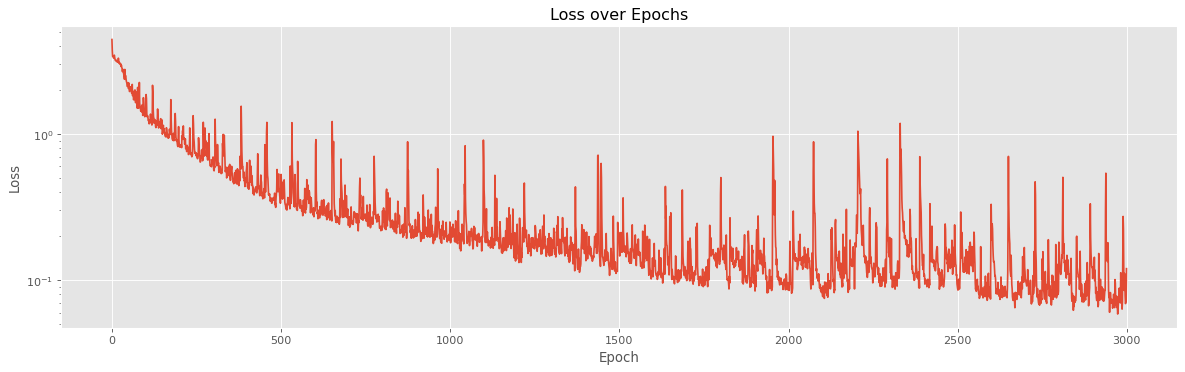

In [43]:
# Plot the loss of the model as each epoch passes
plt.figure(figsize=(18,5), dpi=80)
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])
plt.title('Loss over Epochs');

In [44]:
# Use the fitted LSTM to predict on the test set
y_pred = m.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.set_index(X_test.index, inplace=True)

12/12 [==============================] - 1s 3ms/step


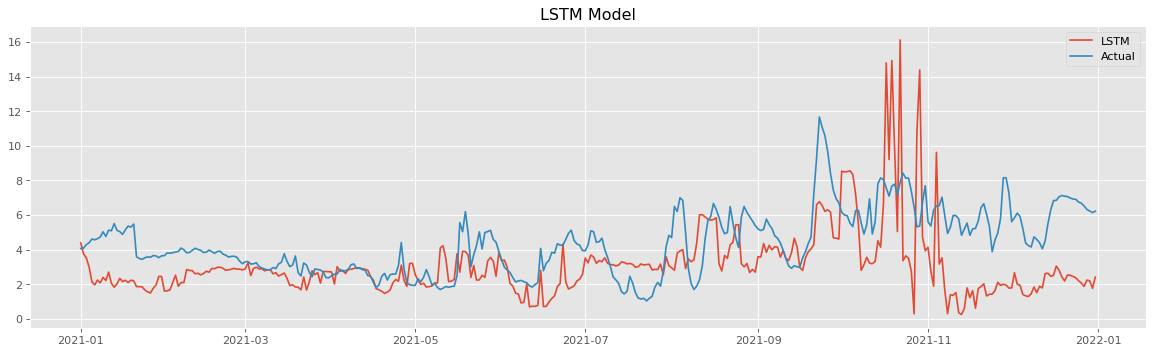

In [45]:
# Plot the LSTM results
plt.figure(figsize=(18,5), dpi=80)
plt.plot(y_pred,label='LSTM')
plt.plot(y_test,label='Actual')
plt.title('LSTM Model')
plt.legend();

In [46]:
# Calculate correlation between predictions and actual values
pd.DataFrame(y_test)['Turb_FNU'].corr(pd.DataFrame(y_pred)[0])

0.367233411920398

In [47]:
# Calculate RMSE
dibrinse = (pd.DataFrame(y_test)['Turb_FNU']-pd.DataFrame(y_pred)[0])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

1.1373817719220303

The predicted and actual values for turbidity in 2021 are displayed in the graph above. Many of the peaks and valleys match up even though their magnitude may not always match. The RMSE here is relatively low, roughly a third of that of the VAR model, and shows that for any given point in time, the model is on average only off by 1.14.

While the RMSE for this model is not as high as that of the OLS model, this model stands to improve the most without considering new variables, given that the machine learning element of this model automatically picks up the signal, and that the loss is steadily decreasing, even after 3000 epochs.

## Conclusions

All three models have their merits, and picking one requires knowledge of their underlying principles and the desired result. The fastest way to get a low variance prediction that is closest to the mean of forecasted values is the OLS regression. This model also has the added advantage of describing the relationship of the predictor variables to the turbidity, which is one of the major goals of this project. The most important factors are precipitation and snowmelt at White Elephant, which feeds rivers upstream in the Mack's Inn area, precipitation and snowmelt at the Island Park Dam, dissolved oxygen, which decreases as turbidity goes up, conductivity, with a positive correlation with turbidity, and temperature at both Island Park Dam and White Elephant. The disadvantage of this model is that it needs estimates for the future values of these explanatory variables in order to work.

The VAR model is possibly the best to use when you have no future data and this is its strongest point. The predictions it generates approximate the typical year of turbidity, with some flaws. The variance at the start of the year is a little too much, and the peaks do not line up exactly when they should happen, although this latter problem is likely caused by meteorological events not included in our data.

The LSTM model is the most adaptible, and can forecast with or without the explanatory variables provided. In this way it acts as sort of a blend of the previous two models, and with a relatively low RMSE it still predicts spikes in turbidity fairly wel, as opposed to the VAR model. Where the VAR is set up to forecast given no extra information out of the box, the LSTM could in the future use the predictions of the VAR model to provide more accurate results. As far as monitoring the turbidity, the best way to do that is the LSTM model with forecsats for the other variables provided.